In [1]:
import numpy as np
import pandas as pdf
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
tf_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "diamonds",
    seed=41,
    shuffle=True,
    image_size=(256,256),
    batch_size=32
)

Found 14078 files belonging to 8 classes.


# Generarea setului de antrenare si setului de testare

In [3]:
epochs = 5
img_height=80
img_width=80
batch_size=20

In [4]:
def tf_split_data(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=10)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_set = ds.take(train_size)
    val_set = ds.skip(train_size).take(val_size)
    test_set = ds.skip(train_size).skip(val_size)

    return train_set, val_set, test_set

train_ds, val_ds, test_ds = tf_split_data(tf_dataset)
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [5]:
class_names = tf_dataset.class_names
print("class_names: ",class_names)
print("number of classes: ", len(class_names))

class_names:  ['cushion', 'emerald', 'heart', 'marquise', 'oval', 'pear', 'princess', 'round']
number of classes:  8


In [6]:
len(train_ds), len(test_ds)

(352, 44)

In [7]:
import tensorflow as tf
import os
#identify wrong images
def test_image_loading(image_directory):
    for subdir, dirs, files in os.walk(image_directory):
        for file in files:
            file_path = os.path.join(subdir, file)
            try:
                image = tf.io.read_file(file_path)
                image = tf.io.decode_image(image)
                #print(f"Successfully decoded: {file_path}")
            except tf.errors.InvalidArgumentError as e:
                print(f"Failed to decode: {file_path}")
            except Exception as e:
                print(f"Other error with file {file_path}: {e}")

test_image_loading("diamonds")

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [9]:
labels_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 2, 5, 7, 1, 0, 2, 4, 7, 4, 7, 1, 0, 3, 2, 4, 5, 3, 7, 7, 5, 4,
       0, 5, 4, 1, 6, 4, 1, 2, 6, 6])>

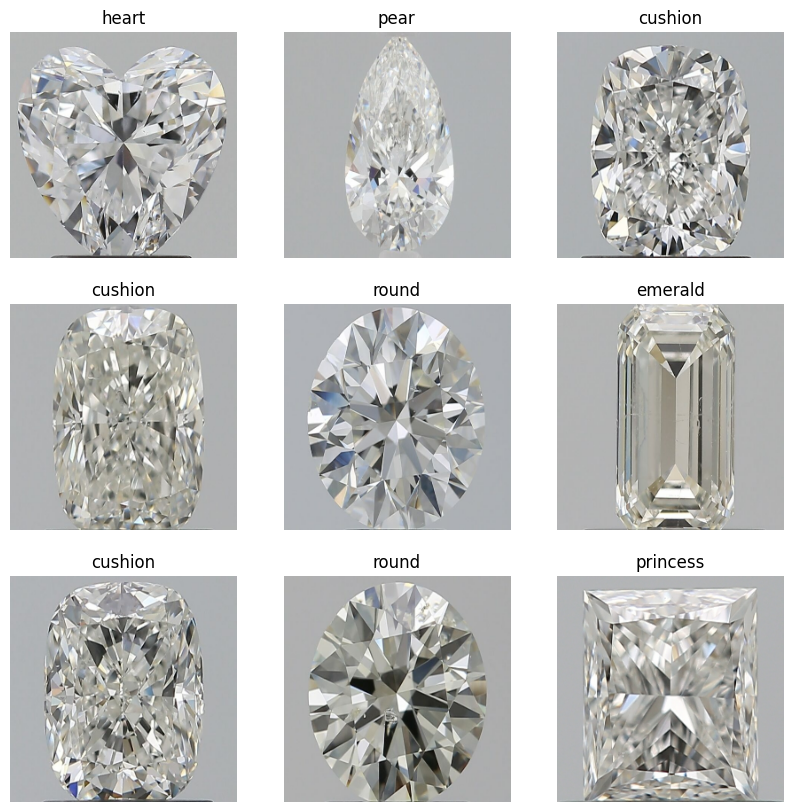

In [10]:
import matplotlib.pyplot as plt
import time
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
   # t0 = time.clock()
 #   print (time.clock() - t0, "seconds process time")

In [11]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
data_augmentation = keras.Sequential(
  [
   layers.RandomFlip("horizontal"),
   layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
]
)

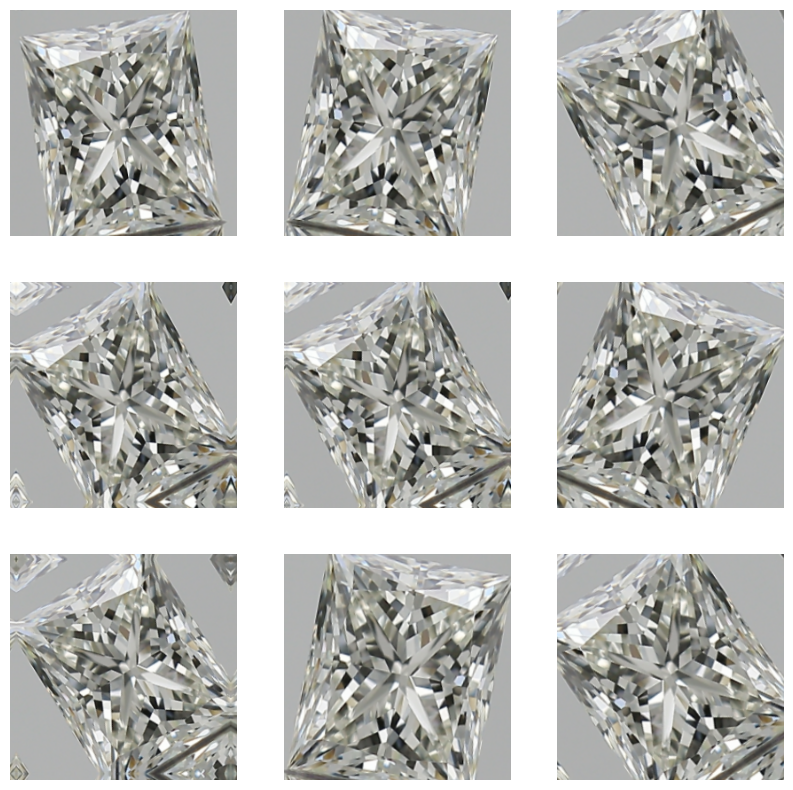

In [12]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
   for i in range(9):
      augmented_images = data_augmentation(images)
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(augmented_images[0].numpy().astype("uint8"))
      plt.axis("off")

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

num_classes = len(class_names)
model_05 = Sequential([
  data_augmentation,
  layers.Conv2D(32, 3, padding='same', activation='relu'),
   #layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
layers.Dense(128, activation='softmax'),
])

In [15]:
from tensorflow.keras.utils import plot_model
input_shape = (None,256, 256, 3)
#model_05.build(input_shape=input_shape)
#model_05.build()
plot_model(model_05, to_file='model1.png')
model_05.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 256, 256, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 128, 128, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 524288)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 128)                   │      67,108,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 128)                   │          16,512 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,126,400 (256.07 MB)

 Trainable params: 67,126,400 (256.07 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model_05.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:

epochs = 10
history = model_05.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
model_05.save("cnn.keras")

Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 399s 1s/step - accuracy: 0.4551 - loss: 756.0919 - val_accuracy: 0.8665 - val_loss: 1.4489
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 360s 1s/step - accuracy: 0.7428 - loss: 1.5299 - val_accuracy: 0.7393 - val_loss: 3.4024
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 353s 942ms/step - accuracy: 0.7652 - loss: 1.2113 - val_accuracy: 0.8608 - val_loss: 1.4179
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 327s 928ms/step - accuracy: 0.8130 - loss: 1.1448 - val_accuracy: 0.8643 - val_loss: 1.8665
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 332s 944ms/step - accuracy: 0.7528 - loss: 1.2332 - val_accuracy: 0.7727 - val_loss: 2.1076
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 334s 950ms/step - accuracy: 0.8011 - loss: 0.8866 - val_accuracy: 0.8047 - val_loss: 2.1653
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 380s 945ms/step - accuracy: 0.8185 - loss: 0.7385 - val_accuracy: 0.8402 - val_loss: 1.1488
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 380s 940ms/step - accuracy: 0.8612 - los

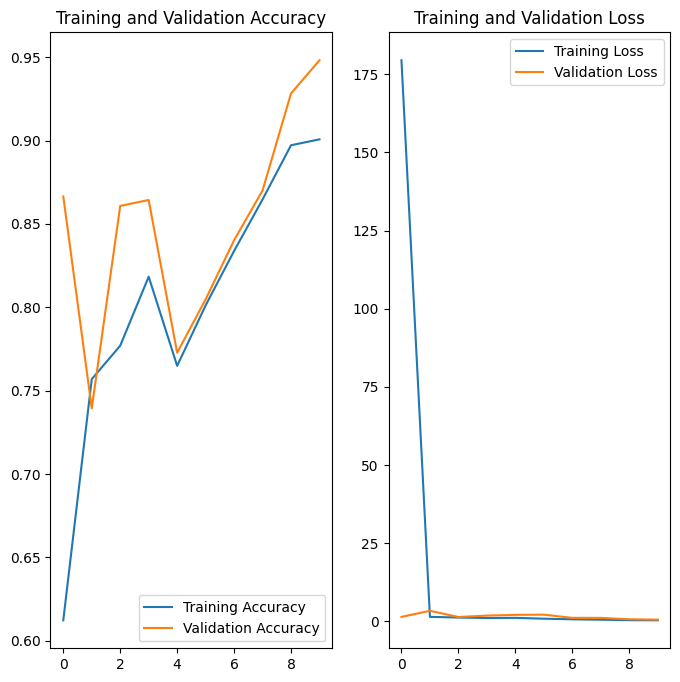

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
#model = model_05  # Get model (Sequential, Functional Model, or Model subclass)
#model_05.save('diamonds_model')

In [20]:
test_images = []
test_labels = []
for image, label in test_ds.take(-1):
  test_images.extend(image)
  test_labels.extend(label)
test_images = np.array(test_images)
test_labels = np.array(test_labels)
print(test_images.shape)
print(test_labels.shape)

(1408, 256, 256, 3)
(1408,)


In [21]:
test_loss, test_acc = model_05.evaluate(test_images,  test_labels, verbose=2)

44/44 - 6s - 134ms/step - accuracy: 0.9425 - loss: 0.5944


In [22]:
print(test_acc)

0.9424715638160706


In [23]:
pred_labels1 = model_05.predict(test_ds)
pred_labels = np.argmax(pred_labels1, axis=1)

44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step


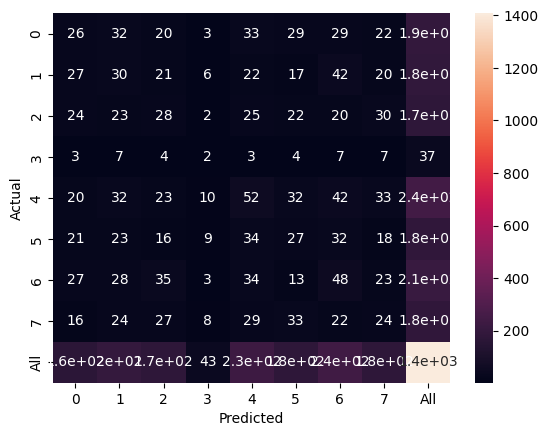

In [24]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

data = {'y_Actual':    test_labels,
        'y_Predicted': pred_labels
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = True)

sn.heatmap(confusion_matrix, annot=True)
plt.show()

In [25]:
# confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(test_labels, pred_labels)
print(cm)
#results(model_05)

[[26 32 20  3 33 29 29 22]
 [27 30 21  6 22 17 42 20]
 [24 23 28  2 25 22 20 30]
 [ 3  7  4  2  3  4  7  7]
 [20 32 23 10 52 32 42 33]
 [21 23 16  9 34 27 32 18]
 [27 28 35  3 34 13 48 23]
 [16 24 27  8 29 33 22 24]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

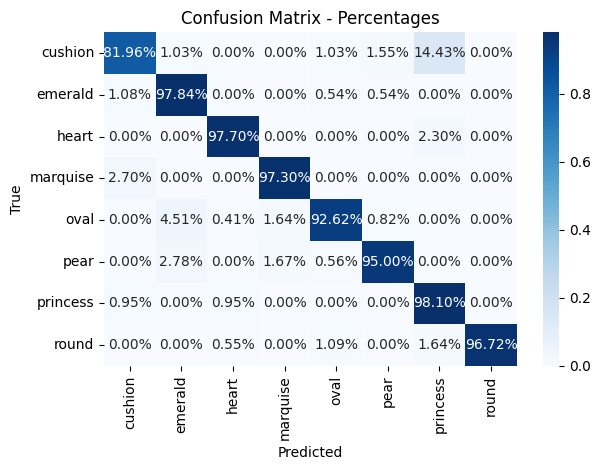

              precision    recall  f1-score   support

           0       0.97      0.82      0.89       194
           1       0.91      0.98      0.94       185
           2       0.98      0.98      0.98       174
           3       0.84      0.97      0.90        37
           4       0.97      0.93      0.95       244
           5       0.97      0.95      0.96       180
           6       0.86      0.98      0.91       211
           7       1.00      0.97      0.98       183

    accuracy                           0.94      1408
   macro avg       0.94      0.95      0.94      1408
weighted avg       0.95      0.94      0.94      1408



In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def get_true_labels_and_predictions(model, dataset):
    true_labels = []
    predictions = []
    for batch in dataset:  
        images, labels = batch
        preds = model.predict(images)
        true_labels.extend(labels.numpy())
        predictions.extend(np.argmax(preds, axis=1))
    return true_labels, predictions

true_labels, predicted_labels = get_true_labels_and_predictions(model_05, test_ds)

cm = confusion_matrix(true_labels, predicted_labels)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#plt.subplot(1, 2, 2) 


sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Percentages')

plt.tight_layout() 
plt.show()

from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_labels))
#print(classification_report(true_labels, predicted_labels, target_names=class_names))

In [27]:
acc=(cm[0,0]+cm[1,1])/(cm[0,0]+cm[1,1]+cm[0,1]+cm[1,0])
print(acc)

0.9883720930232558


In [28]:
#from tensorflow.keras.models import save_model, load_model
#import pickle
#save_model(model_05, 'diamonds_strat_5ep.keras')